# Estimate the activity rising time from calcium traces

This is a simple script to estimate the rising time of calcium traces. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
from scipy.signal import savgol_filter
from scipy import stats
import matplotlib.colors as mcolors
import statsmodels.api as sm
from scipy.optimize import curve_fit


%matplotlib inline

In [2]:
## Select data file to analysis
data_select = "35mm"
if data_select == "35mm":
    data_file = './data/calcium_data_1205.xlsx'
elif data_select == "96well":
    data_file = './data/iPSC_calcium imaging 96 well_quantification_for Shan.xlsx'
else:
    print("Please select a data file to analysis")

# data_file = './data/iPSC_calcium imaging 96 well_quantification_for Shan.xlsx'

# this is a excel with multiple sheets, open it with pandas
data = pd.ExcelFile(data_file)
sheet_names = data.sheet_names
print(sheet_names)

['35mm dish_ROI19', '35mm_ROI20', '35mm_ROI15', '35mm_ROI17', '35mm_ROI18', '35mm_ROI9-2, repre', '35mm_ROI10', '35mm_ROI12 repre', '35mm_ROI13', '35mm_ROI14', '35mm_ROI7-3', '35mm_ROI18-1-1']


## Set up the parameters of the time series

For the 96 well experiment, the temporal resolution is 20 frames per second. The electric stimuli was applied at 5 seconds.

For the 35mm experiemnt, the time of stimuli application is not monitored. We will use the first 1 s window as the background

In [3]:
time_step = 0.05 # 50 ms

if data_select == "35mm":
    pre_time = 1
    fig_pre_0 = './figures/35mm_slope_expon_rise_'
    result_pre = './results/35mm_slope_expon_rise_' 
elif data_select == "96well":
    pre_time = 5
    fig_pre_0 = './figures/96wells_slope_expon_rise_'
    result_pre = './results/96wells_slope_expon_rise_' 
else:
    print("Unrecognized data file")
pre_steps = int(pre_time/time_step)
post_time = pre_time + 5
post_steps = int(post_time/time_step)

window_size = 10
threshold_scale = 2 # 2 std above the mean
slope_half_window = 4  # number of datapoints used to estimate the slope
# fig_pre_0 = './figures/35mm_' + str(window_size) + '_' + str(threshold_scale) + '_'
# result_pre = './results/35mm_widow_' + str(window_size) + '_'

# fig_pre_0 = './figures/96wells_slope_norm_window_' + str(slope_half_window) + '_' + str(threshold_scale) + '_'
# result_pre = './results/96wells_slope_norm_' + str(slope_half_window)

# fig_pre_0 = './figures/96wells_slope_expon_rise_'
# result_pre = './results/96wells_slope_expon_rise_' 




In [4]:
sheet_names

['35mm dish_ROI19',
 '35mm_ROI20',
 '35mm_ROI15',
 '35mm_ROI17',
 '35mm_ROI18',
 '35mm_ROI9-2, repre',
 '35mm_ROI10',
 '35mm_ROI12 repre',
 '35mm_ROI13',
 '35mm_ROI14',
 '35mm_ROI7-3',
 '35mm_ROI18-1-1']

In [5]:
# get the raw data from each sheet

df1= data.parse(sheet_names[7], header=None, index_col=None)

times = time_step*np.arange(df1.shape[0])


def plot_trace_smooth(df1, window_size, fig_pre, plot_flag=True):
    # calculate the mean and std of the first 1s
    pre_mean = df1.iloc[:pre_steps].mean()
    pre_std = df1.iloc[:pre_steps].std()

    # normalize the data by subtracting the mean and dividing by the mean
    df1_norm = (df1 - pre_mean)/pre_mean

    # smooth curve with a moving average filter
    df1_norm_smooth = df1_norm.rolling(window_size).mean()

    # make a plot of the smoothed data
    if plot_flag:
        plt.figure(figsize=(6,5))
        # add original data points, with symbol dots
        plt.plot(times,df1_norm,'.',markersize=2)
        plt.plot(times,df1_norm_smooth,linewidth=1)
        plt.xlabel('Time (s)',fontsize=14)
        plt.ylabel(r'$\Delta$F/F', fontsize=14)
        plt.title('Smoothed Calcium Data',fontsize=14)
        # set x and y axis font size
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        # save the figure
        fig_name = fig_pre + 'smoothed.pdf'
        plt.savefig(fig_name,dpi=300)
    
    return df1_norm_smooth


### Example traces for publication
We select two pairs of traces to show the typical behavior of the signal delay on the axon

In [6]:
# from scipy.interpolate import UnivariateSpline
def example_trace(trace,times, wid_len=21, poly_order=3,plog_flag = True):
    ''' Analyze the calcium trace, define the peak time, slope, and threshold time
    Input:
        trac: a pandas series, calcium trace
        fig_pre: figure name prefix
        times: time points
        wid_len: window length for Savitzky-Golay filter
        poly_order: polynomial order for Savitzky-Golay filter
        threshold_scale: threshold scale, default is 2 fold of std
    '''
    # trace = df1_norm.iloc[:,0]
    # spl = UnivariateSpline(times, trace)
    try:
        # smooth the curve with a Savitzky-Golay filter
        y_filtered = savgol_filter(trace, window_length=wid_len, polyorder=poly_order)
    except:
        print('Savitzky-Golay filter failed, use lowess filter')
        lowess = sm.nonparametric.lowess(trace, times, frac=0.1)
        y_filtered = lowess[:,1]
        times = lowess[:,0]
        print('Time point changes!')
    # select a time window to analyze the peak and slope
    time_window = [pre_steps,post_steps]
    # find the maximum value of the smoothed curve in the time window between 1s and 8 s
    peak = max(y_filtered[time_window[0]:time_window[1]])
    peak_index = next(i for i, element in enumerate(y_filtered) if element == peak)
    peak_time = times[peak_index]

    mid_peak = peak/2

    y_filtered_sel = y_filtered[time_window[0]:peak_index]
    try:
        index = next(i for i, element in enumerate(y_filtered_sel[::-1]) if element <= mid_peak)
        mid_time = times[peak_index - index]
    except StopIteration as e:
        index = len(y_filtered_sel)
        mid_time = times[time_window[0]]
        print("StopIteration caught, use 1s as the middle point")

    lower_index = max(peak_index - index - slope_half_window, pre_steps)
    upper_index = min(peak_index - index + slope_half_window + 1, peak_index)
    time_sel = times[lower_index : upper_index]
    y_sel = y_filtered[lower_index : upper_index]
    y_sel = y_sel/peak
    # fit a line to the data points
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_sel,y_sel)
    if p_value > 0.01:
        print('p value is larger than 0.01, the slope is not significant')
    y_lin_fit = slope*time_sel + intercept

    # xs = np.linspace(times[0], times[-1], 1000)
    if plog_flag:
        colors = mcolors.TABLEAU_COLORS
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        # plt.figure(figsize=(6,4))
        plt.plot(times,trace,'o',markersize=2, color='gray',alpha=0.5)
        # spl.set_smoothing_factor(0.2)
        plt.plot(times, y_filtered, 'gray', lw=1)
        # plot the linear fit line
        plt.plot(time_sel,  peak*(slope*time_sel + intercept), 'r', lw=1)
        # mark the mid peak with a star
        # if mid_time is not None:
        #     plt.plot(mid_time, mid_peak, '*', markersize=10, color='red')
        # # add a vertical dashed line at the mid peak time
        #     plt.axvline(mid_time,linestyle='--',color='blue', linewidth=1,label='mid peak')
    

        # add slope value as text
        plt.text(0.5, 0.8, 'slope = {:.3f}'.format(slope), fontsize=14,
        color='black', transform=ax.transAxes)
        plt.text(0.5, 0.7, 'p_value = {:.4E}'.format(p_value), fontsize=14,
        color='black', transform=ax.transAxes)
        plt.xlabel('Time (s)', fontsize=20)
        plt.ylabel(r'$\Delta$F/F',fontsize=20)
        # plt.title('ROI {}'.format(number+1),fontsize=20) # ROI index starts from 1
        # set the x and y axis font size
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.show()

    return y_sel, mid_time, time_sel, y_lin_fit, peak

Select one ROI to show

In [7]:
sheet_select = 5
print(sheet_names[sheet_select])
roi_select = [2,8]
df1= data.parse(sheet_names[sheet_select], header=None, index_col=None)
times = time_step*np.arange(df1.shape[0])
pre_mean = df1.iloc[:pre_steps].mean()

pre_std = df1.iloc[:pre_steps].std()
# normalize the data by subtracting the mean and dividing by the mean
df1_norm = (df1 - pre_mean)/pre_mean
num_traces = df1_norm.shape[1]
# select traces
sel_trace = df1_norm.iloc[:,roi_select]

y_sel_1, _, time_sel_1, y_lin_fit_1, peak1 = example_trace(sel_trace.iloc[:,0],times, 
                                                           wid_len=21, poly_order=3,
                                                           plog_flag = False)
y_sel_2, _, time_sel_2, y_lin_fit_2, peak2 = example_trace(sel_trace.iloc[:,1],times, 
                                                           wid_len=21, poly_order=3,
                                                           plog_flag = False)

35mm_ROI9-2, repre


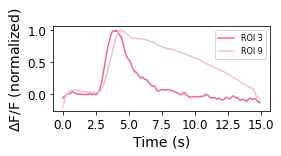

In [9]:
# make plot of the traces
colors = mcolors.TABLEAU_COLORS
my_pink = '#f3c2c2'
my_blue = '#88cff1'
new_pink = (247/256,101/256,148/256)
# fig size
fig,ax = plt.subplots(figsize=(4,2))
# plot the traces
ax.plot(times,sel_trace.iloc[:,0]/peak1,'-',color=new_pink,linewidth=1.5, label='ROI ' + str(roi_select[0]+1))
ax.plot(times,sel_trace.iloc[:,1]/peak2,'-',color=my_pink,linewidth=1.5, label='ROI '+ str(roi_select[1]+1))
# ax.plot(time_sel_1,y_lin_fit_1,'--',color = 'black', linewidth=1)
# ax.plot(time_sel_2,y_lin_fit_2,'--',color = 'black', linewidth=1)

# x and y labels
ax.set_xlabel('Time (s)',fontsize=14)
ax.set_ylabel(r'$\Delta$F/F (normalized)', fontsize=14)
# show the legend
ax.legend(fontsize=8)
# set x and y axis font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# save the figure
fig_name = fig_pre_0 + sheet_names[sheet_select] + '_example_trace_compare_lw1.pdf'
plt.savefig(fig_name,dpi=300)

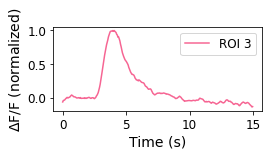

In [10]:
# make two seperate figures for each trace
fig,ax = plt.subplots(figsize=(4,2))
# plot the traces
ax.plot(times,sel_trace.iloc[:,0]/peak1,'-',color=new_pink,linewidth=1.5, label='ROI ' + str(roi_select[0]+1))
# ax.plot(time_sel_1,y_lin_fit_1,'--',color = 'black', linewidth=1)
# x and y labels
ax.set_xlabel('Time (s)',fontsize=14)
ax.set_ylabel(r'$\Delta$F/F (normalized)', fontsize=14)
# show the legend
ax.legend(fontsize=12)
# set x and y axis font size    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# save the figure
fig_name = fig_pre_0 + sheet_names[sheet_select] + '_trace' + str(roi_select[0]+1)+ '.pdf'
plt.savefig(fig_name,dpi=300)

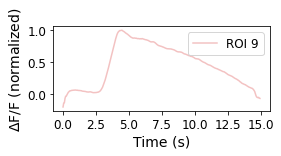

In [11]:
# make two seperate figures for each trace
fig,ax = plt.subplots(figsize=(4,2))
# plot the traces
ax.plot(times,sel_trace.iloc[:,1]/peak2,'-',color=my_pink,linewidth=1.5, label='ROI ' + str(roi_select[1]+1))
# ax.plot(time_sel_2,y_lin_fit_2,'--',color = 'black', linewidth=1)
# x and y labels
ax.set_xlabel('Time (s)',fontsize=14)
ax.set_ylabel(r'$\Delta$F/F (normalized)', fontsize=14)
# show the legend
ax.legend(fontsize=12)
# set x and y axis font size    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# save the figure
fig_name = fig_pre_0 + sheet_names[sheet_select] + '_trace' + str(roi_select[1]+1)+ '.pdf'
plt.savefig(fig_name,dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


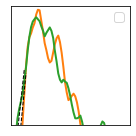

In [66]:
# make plot of the traces
colors = mcolors.TABLEAU_COLORS
# fig size
fig,ax = plt.subplots(figsize=(2,2))
# plot the traces
ax.plot(times,sel_trace.iloc[:,0]/peak1,'-',color=colors['tab:orange'],linewidth=2)
ax.plot(times,sel_trace.iloc[:,1]/peak2,'-',color=colors['tab:green'],linewidth=2)
ax.plot(time_sel_1,y_lin_fit_1,'--',color = 'black', linewidth=1)
ax.plot(time_sel_2,y_lin_fit_2,'--',color = 'black', linewidth=1)

# x and y labels
# ax.set_xlabel('Time (s)',fontsize=14)
# ax.set_ylabel(r'$\Delta$F/F (normalized)', fontsize=14)
# set x and y limits
ax.set_xlim([5,8.5])
ax.set_ylim([0.58,1.05])
# remove axis ticks
ax.set_xticks([])
ax.set_yticks([])
# show the legend
ax.legend(fontsize=12)
# set x and y axis font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# save the figure
fig_name = fig_pre_0 + sheet_names[sheet_select] + '_example_trace_compare_zoom.pdf'
plt.savefig(fig_name,dpi=300)

Zoom in to show the estimation of the rising slope

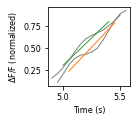

In [18]:
t_low1 = int(time_sel_1[0]/time_step)-2
t_high1 = int(time_sel_1[-1]/time_step)+3
time_window1= times[t_low1:t_high1]

t_low2 = int(time_sel_2[0]/time_step)-2
t_high2 = int(time_sel_2[-1]/time_step)+3
time_window2= times[t_low2:t_high2]
fig,ax = plt.subplots(figsize=(2,1.8))
# plot the traces
# plt.plot(time_sel_1,y_sel_1,'o',color='black',markersize=1)
plt.plot(time_window1,sel_trace.iloc[t_low1:t_high1,0]/peak1, '-',color = 'gray',linewidth=1)
plt.plot(time_sel_1,y_lin_fit_1,color =colors['tab:orange'],linewidth=1)

# plt.plot(time_sel_2,y_sel_2,'o',color='black',markersize=1)
plt.plot(time_window2,sel_trace.iloc[t_low2:t_high2,1]/peak2, '-',color = 'gray',linewidth=1)
plt.plot(time_sel_2,y_lin_fit_2,color =colors['tab:green'],linewidth=1)

# add x label
plt.xlabel('Time (s)',fontsize=8)
plt.ylabel(r'$\Delta$F/F (normalized)',fontsize=8)
# set x and y axis font size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# save as a pdf
plt.tight_layout()
fig_name = fig_pre_0 + sheet_names[sheet_select] + '_example_trace_compare_zoom_without_smooth.pdf'
plt.savefig(fig_name,dpi=300)


### Function to estimate the rising time and slope at middle point

In [68]:
# from scipy.interpolate import UnivariateSpline
def trace_analysis(trace,fig_pre,times, number, wid_len=21, poly_order=3, threshold_scale=2, plog_flag = True):
    ''' Analyze the calcium trace, define the peak time, slope, and threshold time
    Input:
        trac: a pandas series, calcium trace
        fig_pre: figure name prefix
        times: time points
        number: index of the region in one sheet
        wid_len: window length for Savitzky-Golay filter
        poly_order: polynomial order for Savitzky-Golay filter
        threshold_scale: threshold scale, default is 2 fold of std
    '''
    # trace = df1_norm.iloc[:,0]
    # spl = UnivariateSpline(times, trace)
    try:
        # smooth the curve with a Savitzky-Golay filter
        y_filtered = savgol_filter(trace, window_length=wid_len, polyorder=poly_order)
    except:
        print('Savitzky-Golay filter failed, use lowess filter')
        lowess = sm.nonparametric.lowess(trace, times, frac=0.1)
        y_filtered = lowess[:,1]
        times = lowess[:,0]
        print('Time point changes!')

    # find the start time based on threshold
    pre_mean = np.mean(y_filtered[:pre_steps])
    pre_std = np.std(y_filtered[:pre_steps])
    data_range = y_filtered[pre_steps:]
    threshold = pre_mean + threshold_scale*pre_std

    # find the time points that are above the threshold
    try:
        index_thd= next(i for i, element in enumerate(data_range) if element >= threshold)
    except StopIteration as e:
        index_thd = None
        print("StopIteration caught")
    if index_thd is not None:
        time_threshold = times[index_thd + pre_steps]
    else:
    # Handle the case when no element in data_range is greater than threshold
        time_threshold = None
    # time_threshold = times[index_thd+pre_steps]

    # select a time window to analyze the peak and slope
    time_window = [pre_steps,post_steps]
    # find the maximum value of the smoothed curve in the time window between 1s and 8 s
    peak = max(y_filtered[time_window[0]:time_window[1]])
    peak_index = next(i for i, element in enumerate(y_filtered) if element == peak)
    peak_time = times[peak_index]

    mid_peak = peak/2
    # find the first time point that is above the threshold
    # y_filtered_sel = y_filtered[time_window[0]:time_window[1]]
    y_filtered_sel = y_filtered[time_window[0]:peak_index]
    # find the last time point that y_filtered_sel is below mid_peak
    # flag = y_filtered_sel < mid_peak
    # find the last index of flag that is Ture
    # index = last_index_smaller_than(y_filtered_sel, mid_peak)
    try:
        index = next(i for i, element in enumerate(y_filtered_sel[::-1]) if element <= mid_peak)
        mid_time = times[peak_index - index]
    except StopIteration as e:
        index = len(y_filtered_sel)
        mid_time = times[time_window[0]]
        print("StopIteration caught, use 1s as the middle point")

    # seelct 7 data point around the middle peak point
    # time_sel = times[time_window[0]+index - 3 : time_window[0]+index + 4]
    # y_sel = y_filtered[time_window[0]+index - 3 : time_window[0]+index + 4]
    lower_index = max(peak_index - index - slope_half_window, pre_steps)
    upper_index = min(peak_index - index + slope_half_window + 1, peak_index)
    time_sel = times[lower_index : upper_index]
    y_sel = y_filtered[lower_index : upper_index]
    # normalize the y_sel by the peak value
    y_sel = y_sel/peak
    # fit a line to the data points
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_sel,y_sel)
    if p_value > 0.01:
        print('p value is larger than 0.01, the slope is not significant')

    # estimate the 2nd derivative at the middle of the peak
    time_sel_mid = times[pre_steps:peak_index]
    y_sel_mid = y_filtered[pre_steps:peak_index]
    derivative = np.gradient(y_sel_mid, time_sel_mid)
    derivative2 = np.gradient(derivative, time_sel_mid)
    # find the index of the largest 2nd derivative
    index = np.argmax(derivative2)
    # find the time point of the largest 2nd derivative
    max2d_time = time_sel_mid[index]

    # xs = np.linspace(times[0], times[-1], 1000)
    if plog_flag:
        colors = mcolors.TABLEAU_COLORS
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        # plt.figure(figsize=(6,4))
        plt.plot(times,trace,'o',markersize=2, color='gray',alpha=0.5)
        # spl.set_smoothing_factor(0.2)
        plt.plot(times, y_filtered, 'gray', lw=1)
        # plot the linear fit line
        plt.plot(time_sel,  peak*(slope*time_sel + intercept), 'r', lw=1)
        # mark the mid peak with a star
        if mid_time is not None:
            plt.plot(mid_time, mid_peak, '*', markersize=10, color='red')
        # add a vertical dashed line at the mid peak time
            plt.axvline(mid_time,linestyle='--',color='blue', linewidth=1,label='mid peak')
        # add a vertical line at the maximum 2nd derivative time
        plt.axvline(max2d_time,linestyle='--',color='orange', linewidth=1, label='max 2nd derivative')
        # add a vertical line at the threshold time
        if time_threshold is not None:
            plt.axvline(time_threshold,linestyle='--',color='green', linewidth=1,label='threshold')

        # add slope value as text
        plt.text(0.5, 0.8, 'slope = {:.3f}'.format(slope), fontsize=14,
        color='black', transform=ax.transAxes)
        plt.text(0.5, 0.7, 'p_value = {:.4E}'.format(p_value), fontsize=14,
        color='black', transform=ax.transAxes)
        plt.xlabel('Time (s)', fontsize=20)
        plt.ylabel(r'$\Delta$F/F',fontsize=20)
        plt.title('ROI {}'.format(number+1),fontsize=20) # ROI index starts from 1
        # set the x and y axis font size
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        # save the figure
        fig_name = fig_pre + '_#' + str(number) + '.pdf'
        # plt.title('Smoothed Calcium Data')
        # save the figure
        plt.savefig(fig_name,dpi=300)

    return mid_time, max2d_time, time_threshold, slope, peak

In [69]:
def piecewise_func(t, y0, t0, tau):
    y = np.piecewise(t, [t < t0, t >= t0],
                     [lambda t:y0, lambda t:y0 + (1-y0)*(1-np.exp(-(t-t0)/tau))])
    return y

In [70]:
# from scipy.interpolate import UnivariateSpline
def fit_rise_time(trace,fig_pre,times,pre_time, number, wid_len=21, poly_order=3, 
                  plog_flag = True, start_time=1, fit_bound=([-5,1,0.1],[0.5,5,5]),
                  return_fit_curve=False):
    ''' Analyze the calcium trace, define the peak time, slope, and threshold time
    Input:
        trac: a pandas series, calcium trace
        fig_pre: figure name prefix
        times: time points
        pre_time: start from this time point to analyze
        number: index of the region in one sheet
        wid_len: window length for Savitzky-Golay filter
        poly_order: polynomial order for Savitzky-Golay filter
    '''
    # trace = df1_norm.iloc[:,0]
    # spl = UnivariateSpline(times, trace)
    try:
        # smooth the curve with a Savitzky-Golay filter
        y_filtered = savgol_filter(trace, window_length=wid_len, polyorder=poly_order)
    except:
        print('Savitzky-Golay filter failed, use lowess filter')
        lowess = sm.nonparametric.lowess(trace, times, frac=0.1)
        y_filtered = lowess[:,1]
        times = lowess[:,0]
        print('Time point changes!')

    # select a time window to analyze the peak and slope
    time_window = [pre_steps,post_steps]
    # find the maximum value of the smoothed curve in the time window between 1s and 8 s
    peak = max(y_filtered[time_window[0]:time_window[1]])
    peak_index = next(i for i, element in enumerate(y_filtered) if element == peak)
    peak_time = times[peak_index]

    pre_time_index = int(pre_time/time_step)
    ts =  times[pre_time_index:peak_index]
    # normalize the y by the peak value
    y_sel = trace[pre_time_index:peak_index]/peak
    # fit the data with the piecewise function
    popt, pcov = curve_fit(piecewise_func, ts, y_sel, p0=[0., start_time, 1],bounds=fit_bound)
    rise_time = popt[1]
    rise_time_scale = popt[2]
    new_t = np.linspace(ts.min(), ts.max(), 201)
    y_pred = piecewise_func(new_t, *popt)
    # xs = np.linspace(times[0], times[-1], 1000)
    if plog_flag:
        colors = mcolors.TABLEAU_COLORS
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        plt.plot(ts,y_sel,'o',markersize=4, color='gray',alpha=0.5)
        plt.plot(new_t, y_pred, 'black', lw=2)
        plt.xlabel('Time (s)', fontsize=20)
        plt.ylabel(r'$\Delta$F/F (normalized)',fontsize=20)
        plt.title('ROI {}'.format(number+1),fontsize=20) # ROI index starts from 1
        # set the x and y axis font size
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        # save the figure
        fig_name = fig_pre + '_#' + str(number) + '.pdf'
        plt.savefig(fig_name,dpi=300)
    if return_fit_curve:
        return rise_time, rise_time_scale, new_t, y_pred, ts, y_sel, peak
    else:
        return rise_time, rise_time_scale

### Analyzing and summarize all the calcium traces

StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


StopIteration caught
StopIteration caught
StopIteration caught, use 1s as the middle point
p value is larger than 0.01, the slope is not significant
StopIteration caught


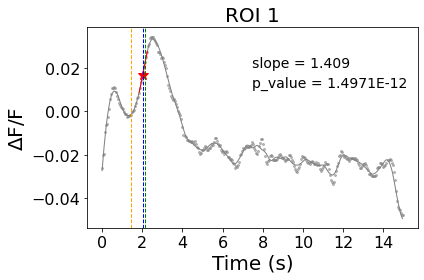

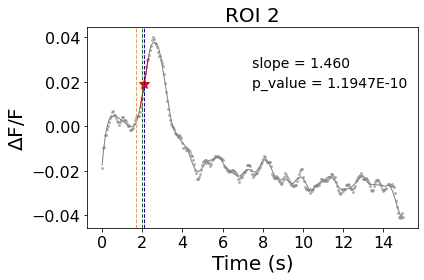

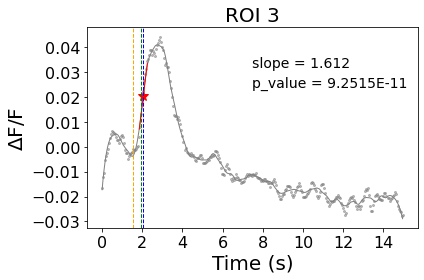

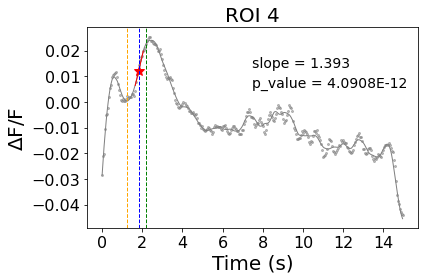

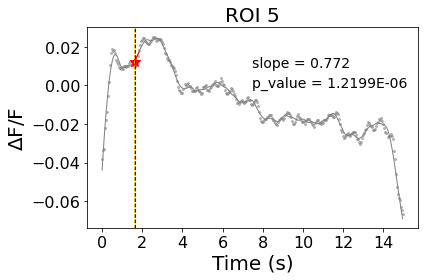

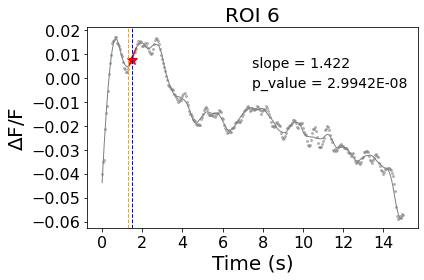

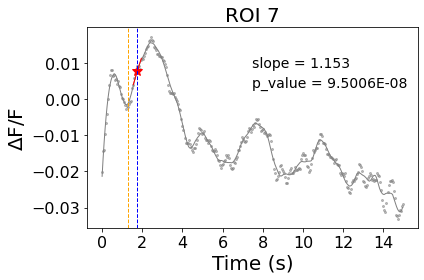

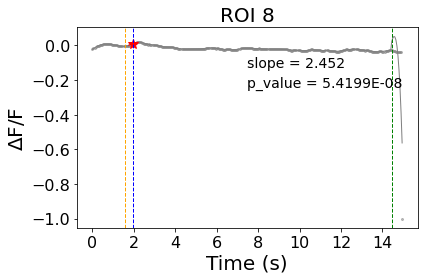

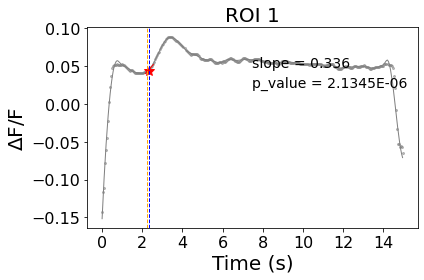

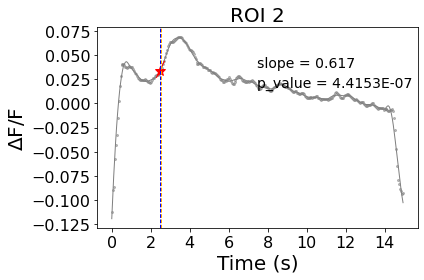

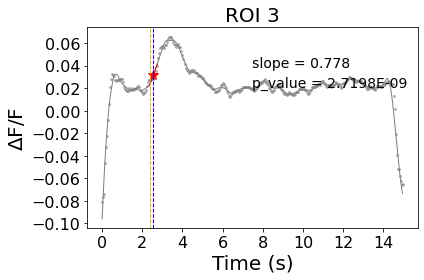

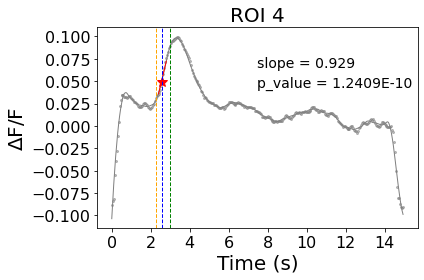

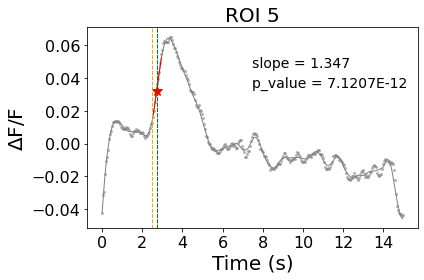

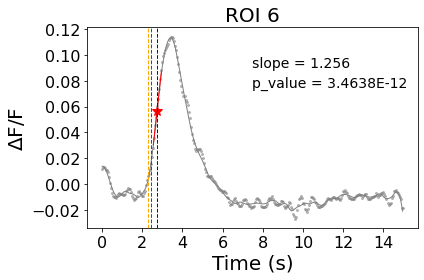

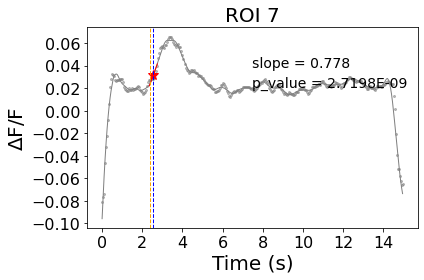

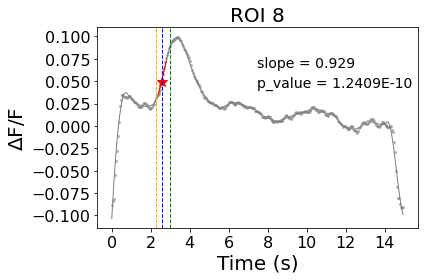

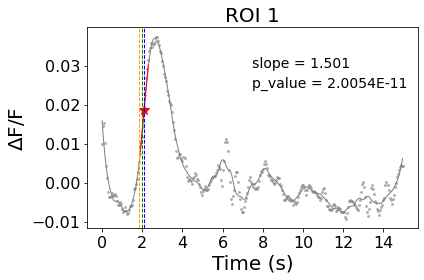

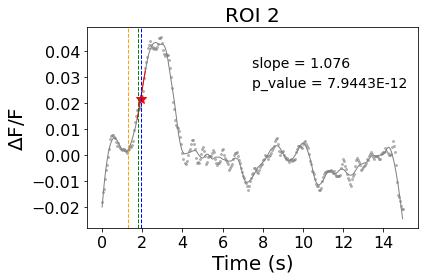

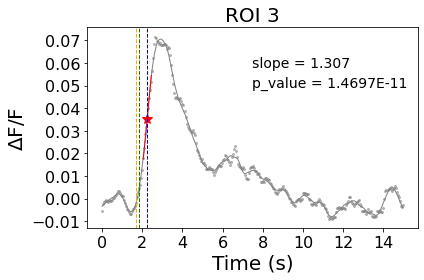

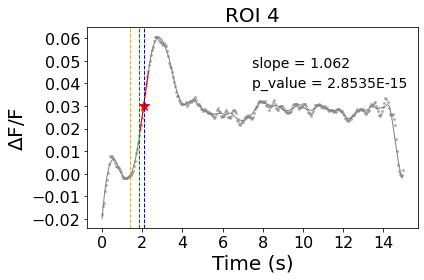

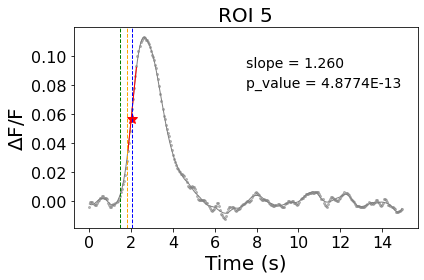

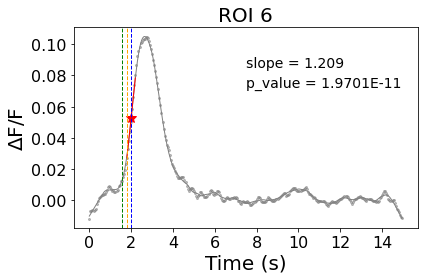

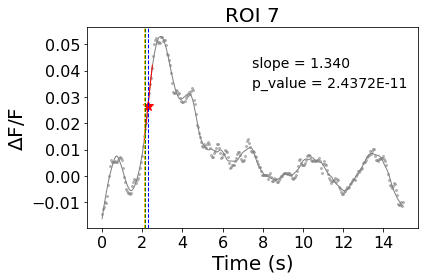

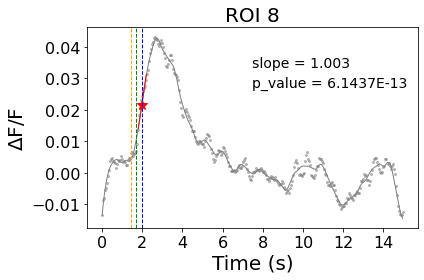

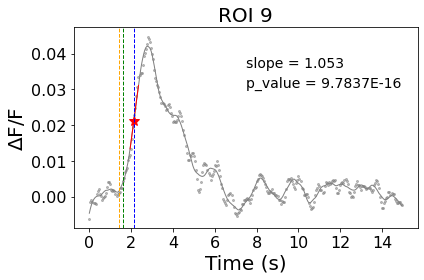

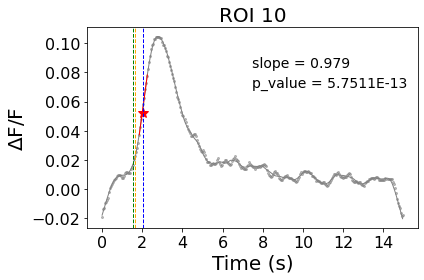

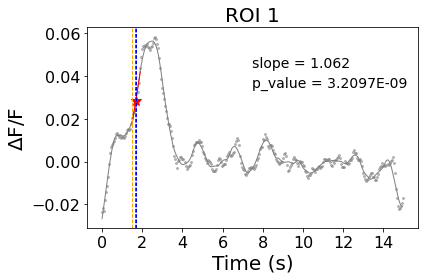

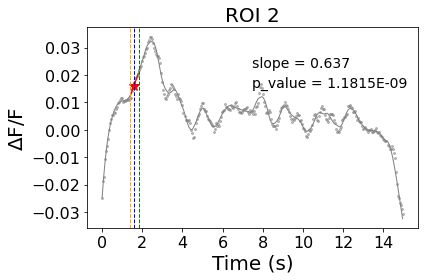

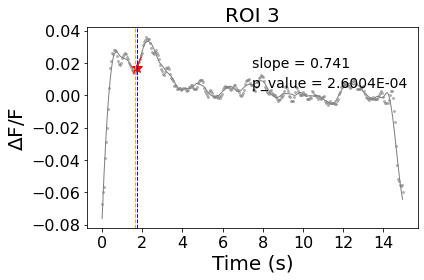

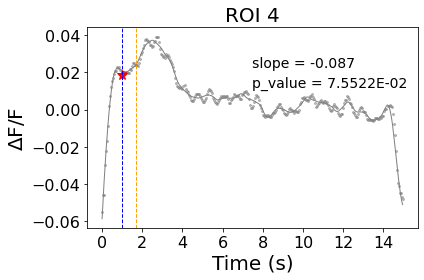

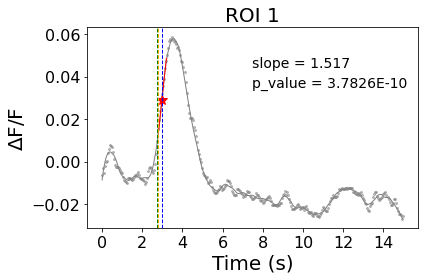

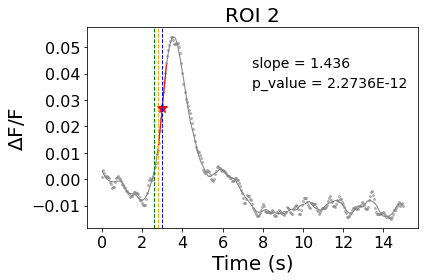

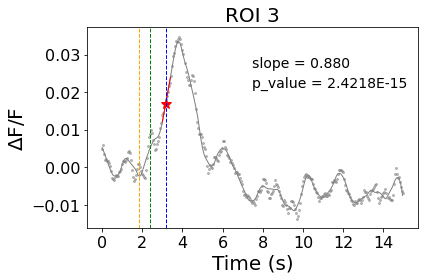

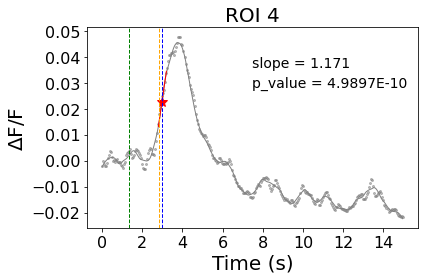

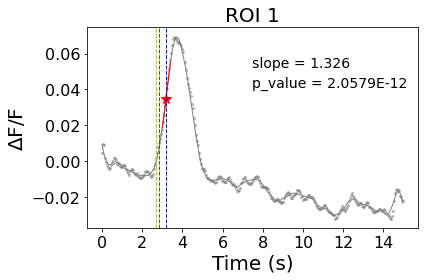

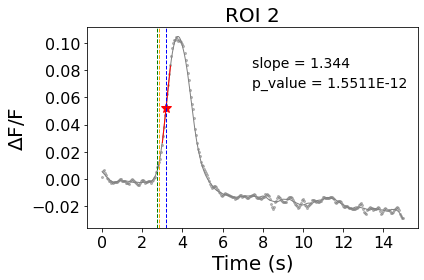

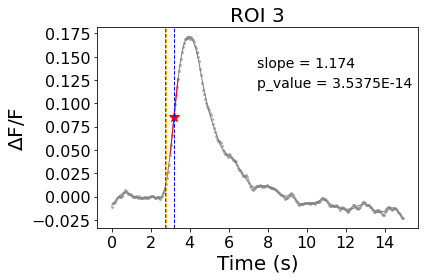

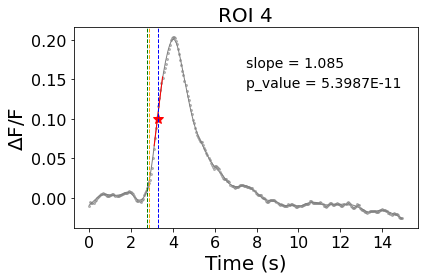

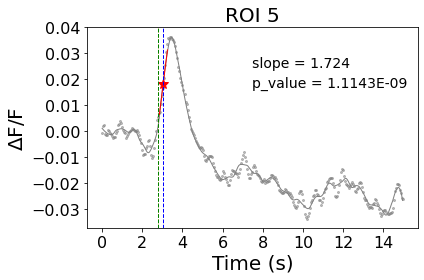

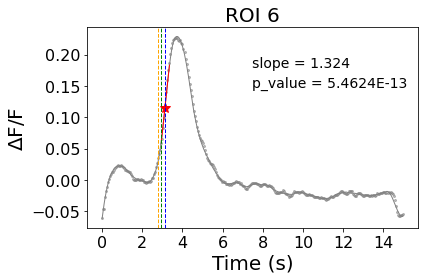

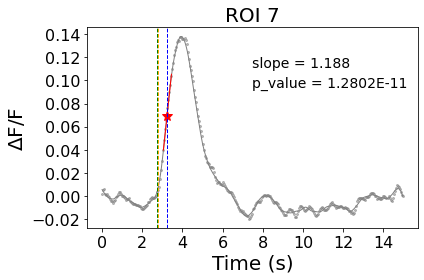

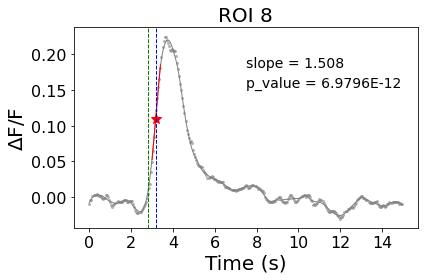

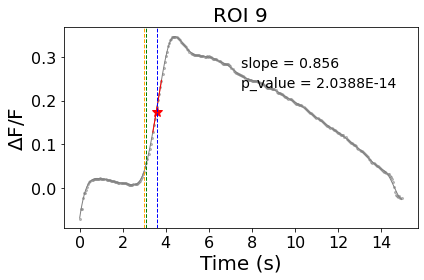

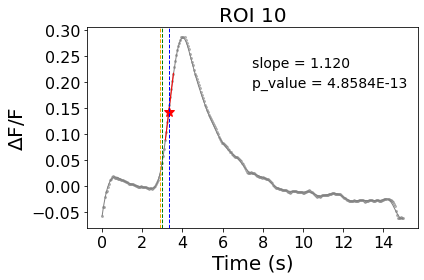

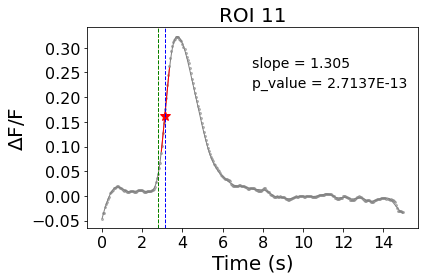

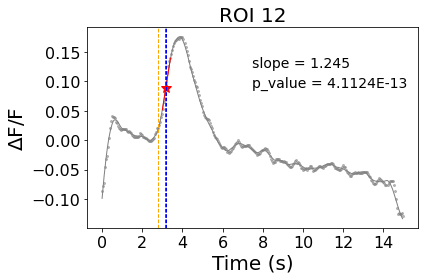

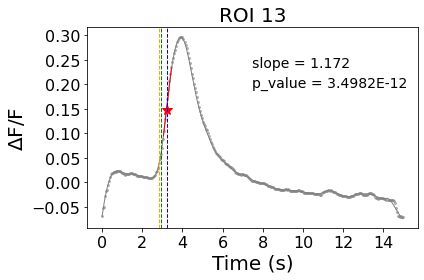

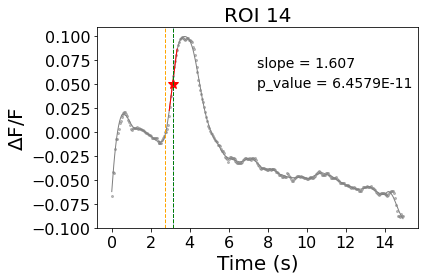

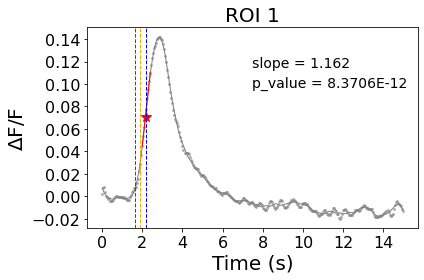

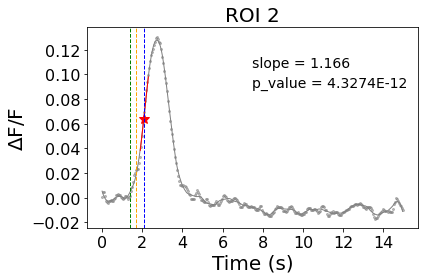

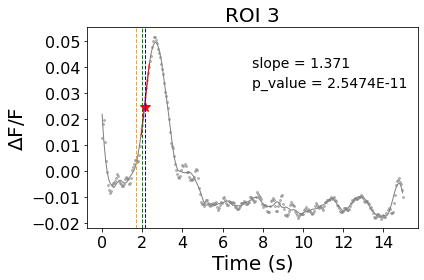

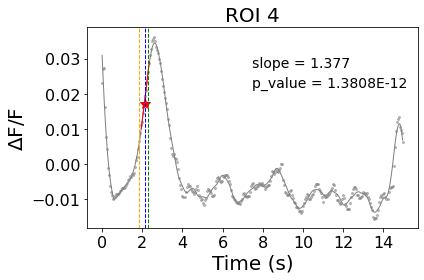

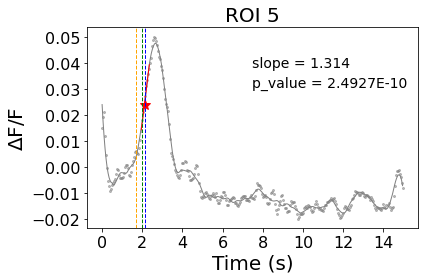

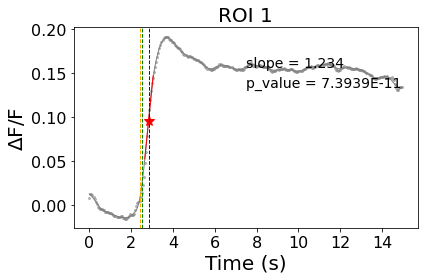

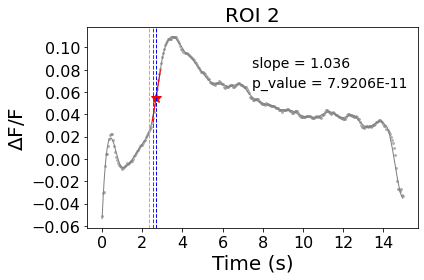

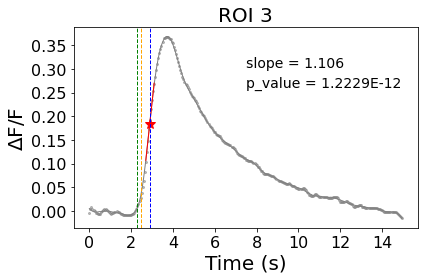

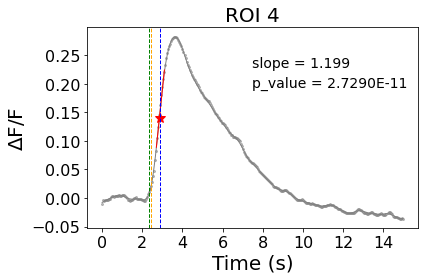

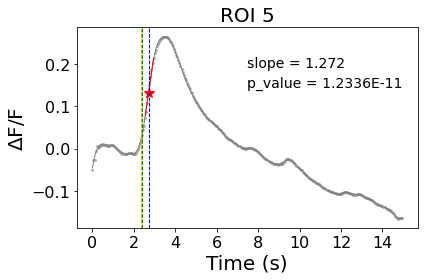

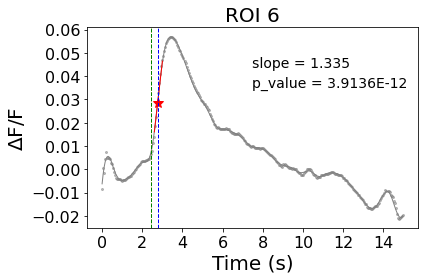

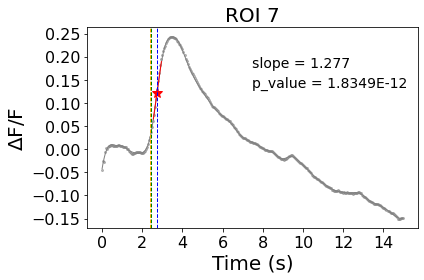

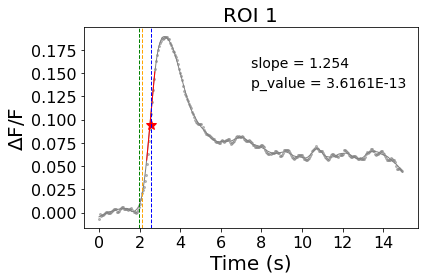

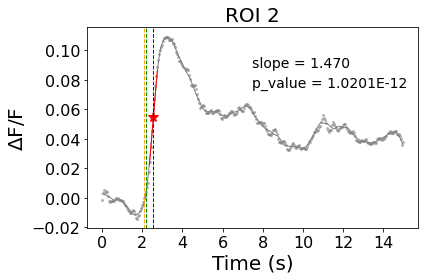

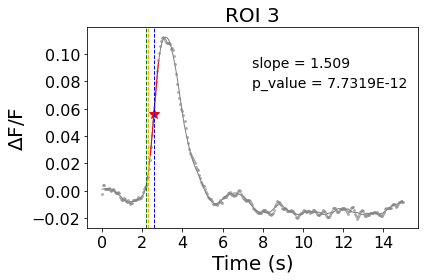

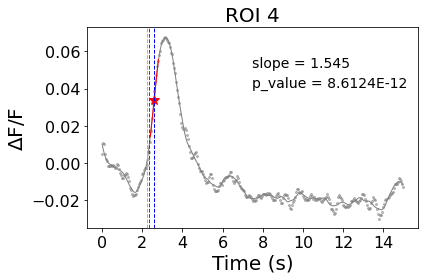

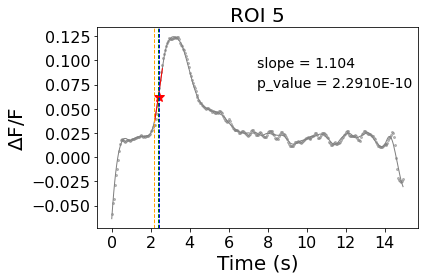

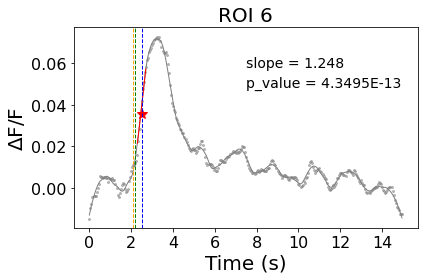

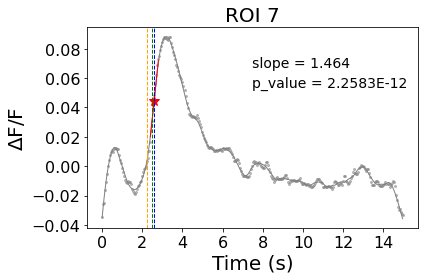

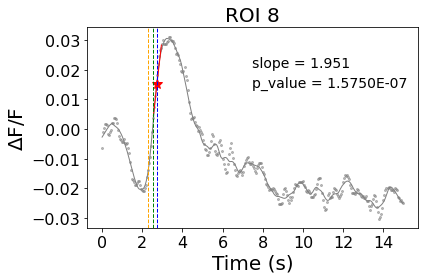

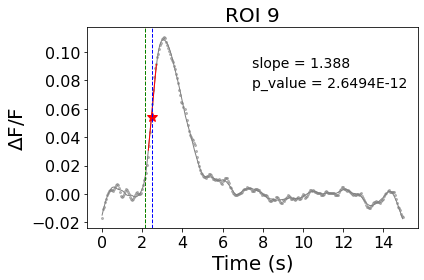

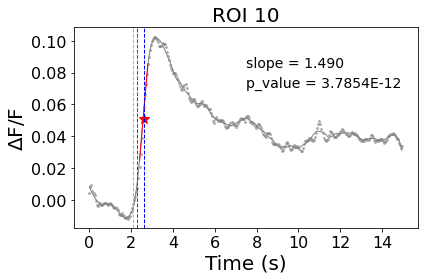

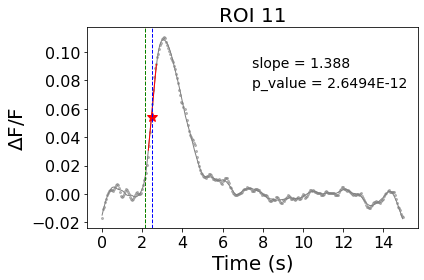

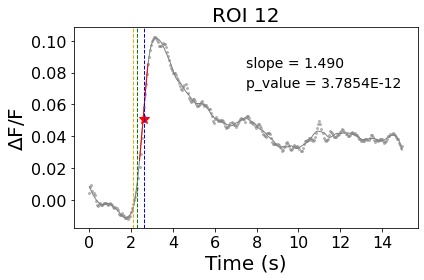

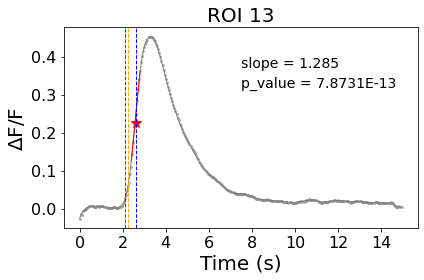

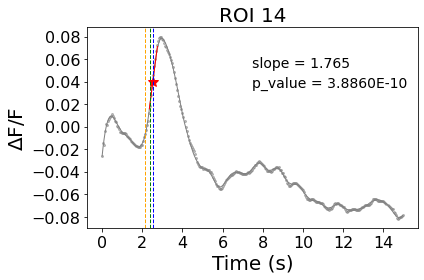

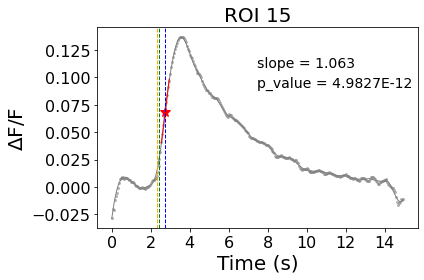

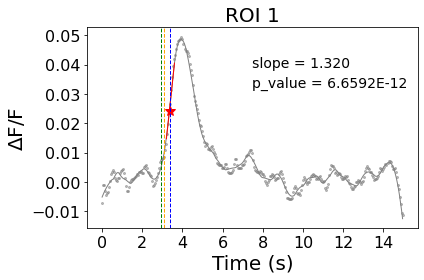

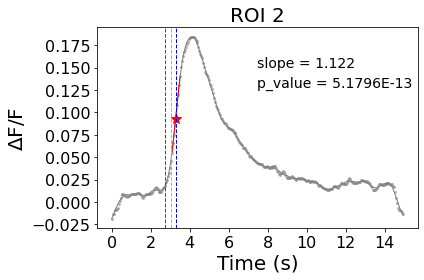

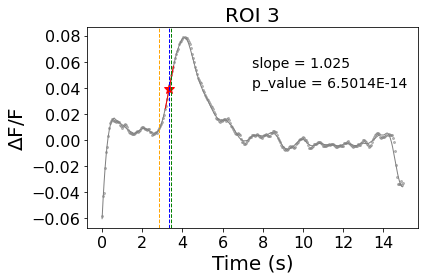

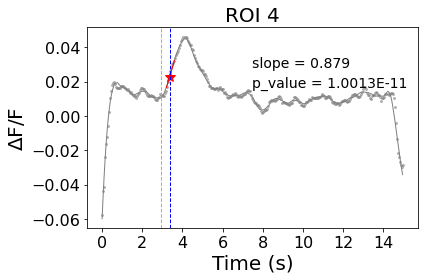

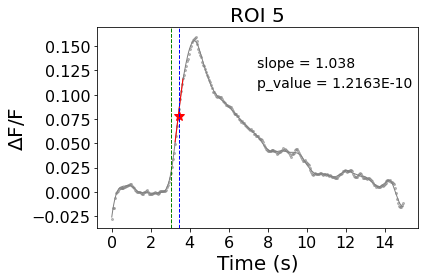

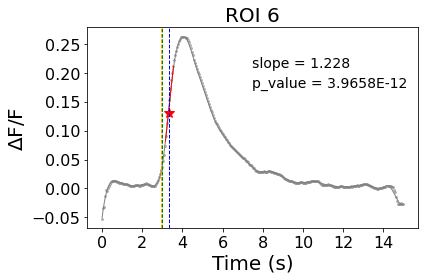

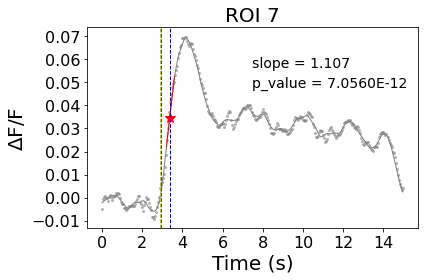

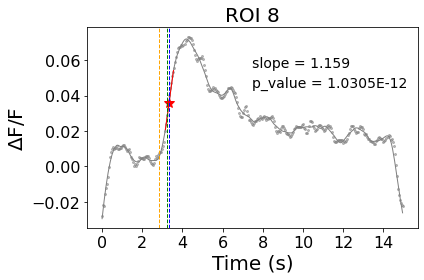

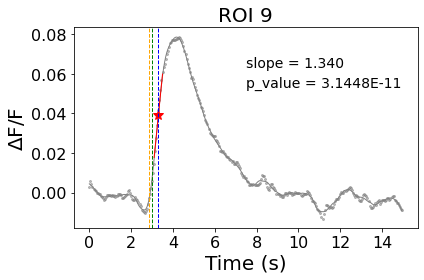

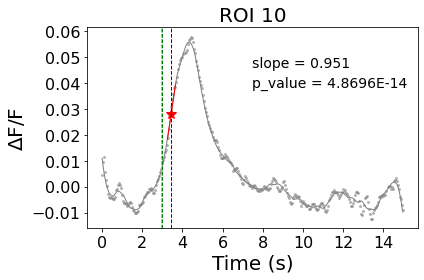

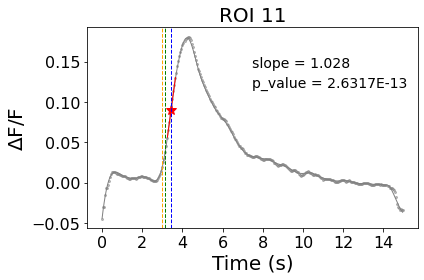

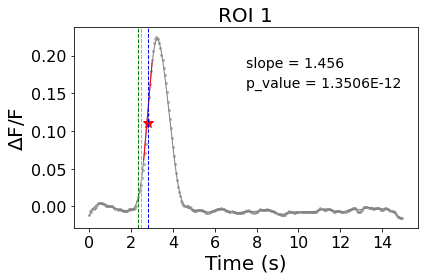

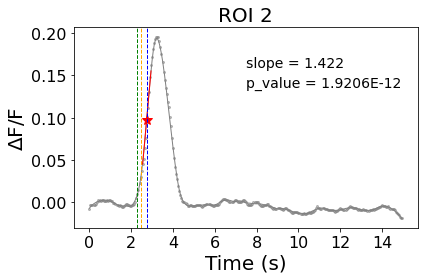

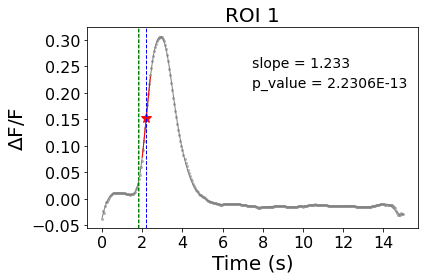

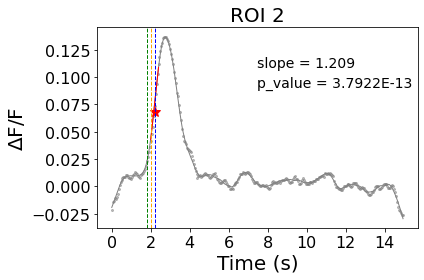

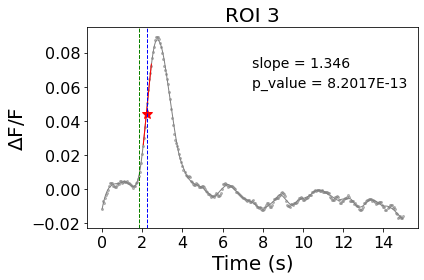

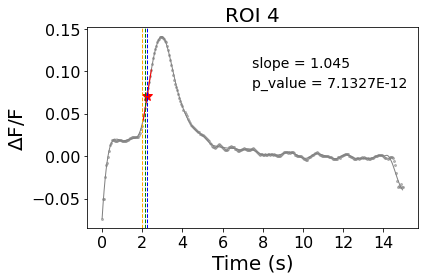

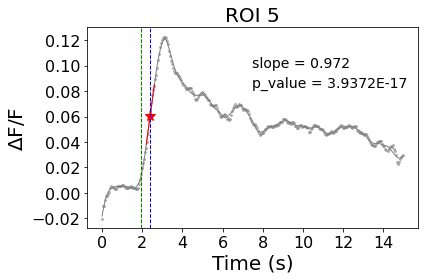

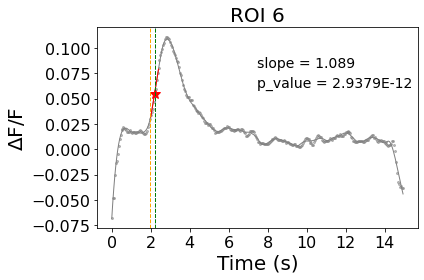

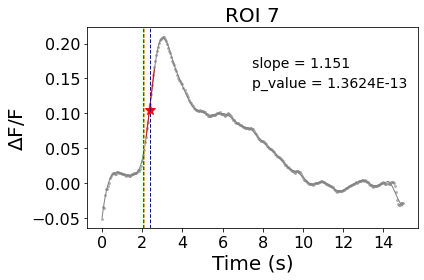

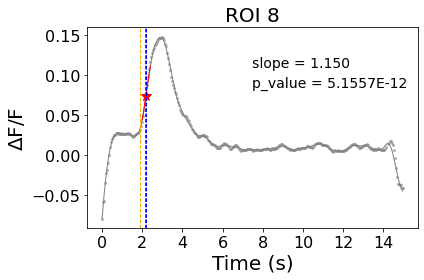

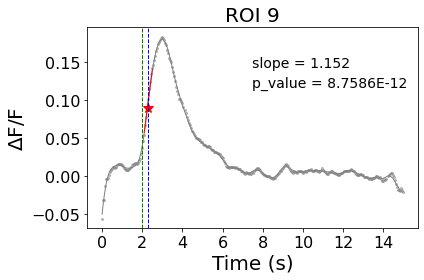

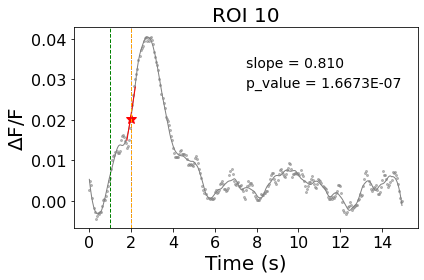

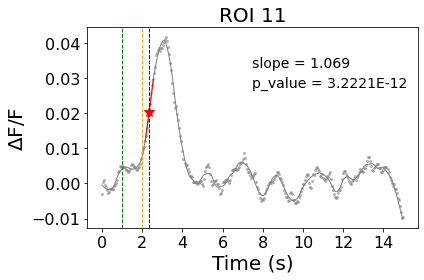

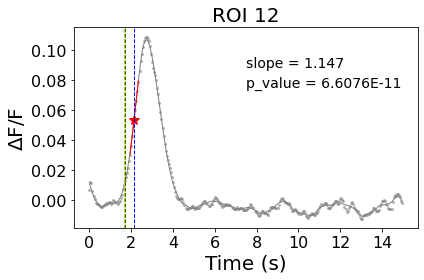

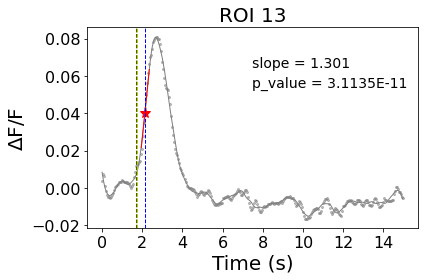

In [6]:
# get the raw data from each sheet
# define a data frame to store the results
df = pd.DataFrame({'mid_time':[],'max2d_time':[],'time_threshold':[],'slope':[], 'peak':[]})

for names in sheet_names:
    df1= data.parse(names, header=None, index_col=None)
    times = time_step*np.arange(df1.shape[0])

    # calculate the mean and std of the first 1s
    pre_mean = df1.iloc[:pre_steps].mean()
    pre_std = df1.iloc[:pre_steps].std()

    # normalize the data by subtracting the mean and dividing by the mean
    df1_norm = (df1 - pre_mean)/pre_mean
    total_cols = df1_norm.shape[1]

    fig_pre = fig_pre_0 + names + '_thd_' + str(threshold_scale) + '_'

    # plot orignial and smoothed data

    # analyze each trace
    row_names = []
    mid_times = []
    max2d_times = []
    time_thresholds =[]
    slopes = []
    peaks = []
    for i in range(total_cols):
        trace = df1_norm.iloc[:,i]
        mid_time, max2d_time, time_threshold, slope, peak = \
        trace_analysis(trace,fig_pre,times,i,plog_flag=True)
    # write mid_time, max2d_time, time_threshold, slope to a csv file, one sheet one file
        row_names.append(names + '_' + str(i))
        mid_times.append(mid_time)
        max2d_times.append(max2d_time)
        time_thresholds.append(time_threshold)
        slopes.append(slope)
        peaks.append(peak)
    df_curr = pd.DataFrame({'mid_time':mid_times,'max2d_time':max2d_times,'time_threshold':time_thresholds,
                            'slope':slopes, 'peak':peaks},index=row_names)
    # df_curr.index = row_names
    df = df.append(df_curr)
# save the final cvs file
file_name = result_pre + 'trace_summary.csv'
df.to_csv(file_name,index=True)


### Fit a exponential function to the rising phase

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


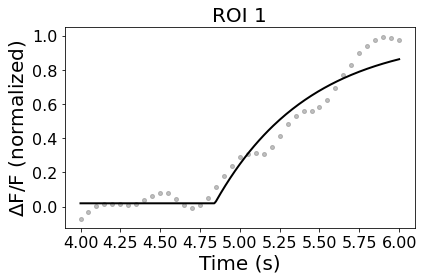

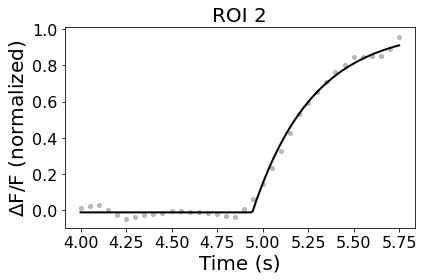

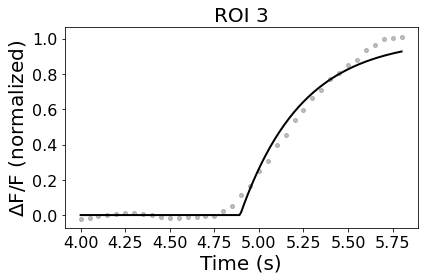

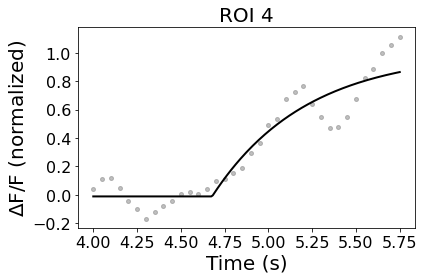

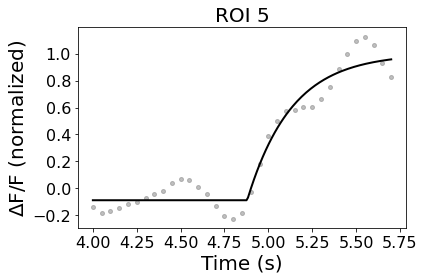

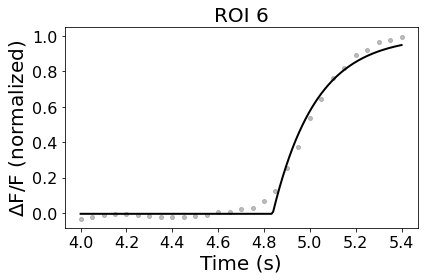

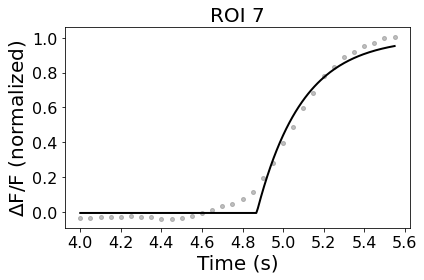

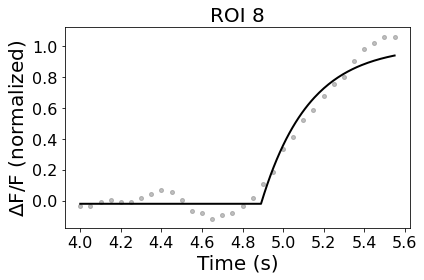

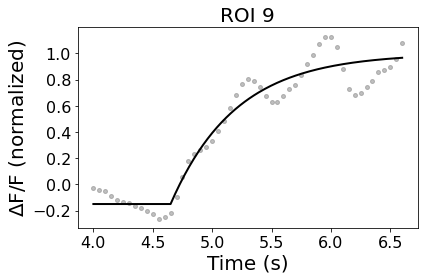

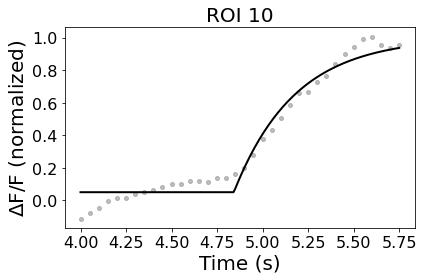

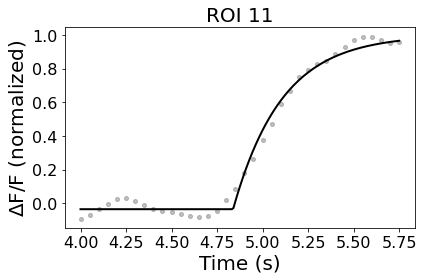

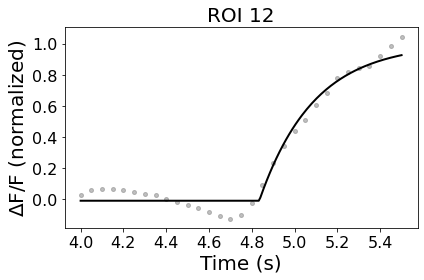

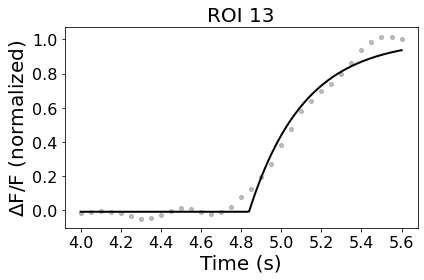

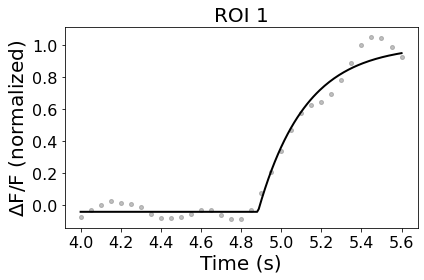

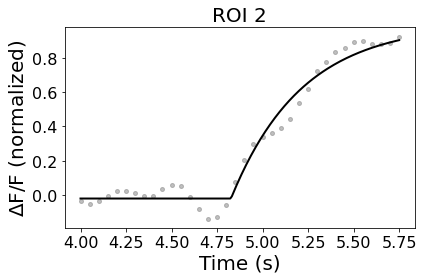

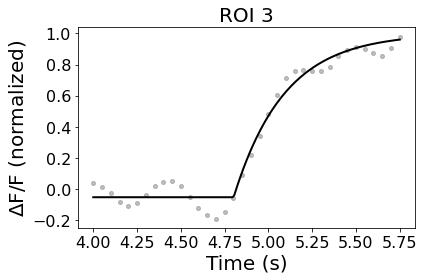

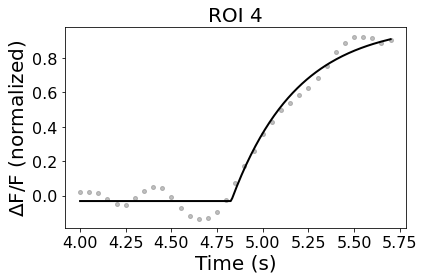

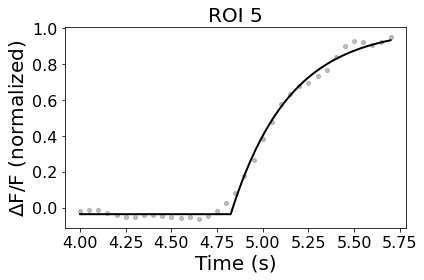

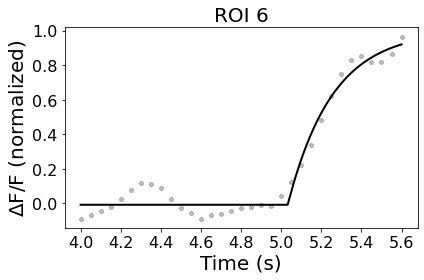

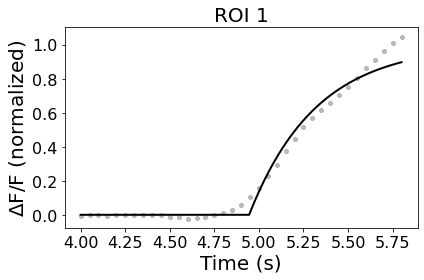

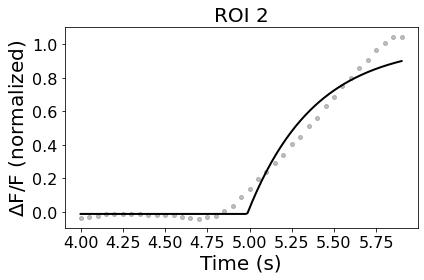

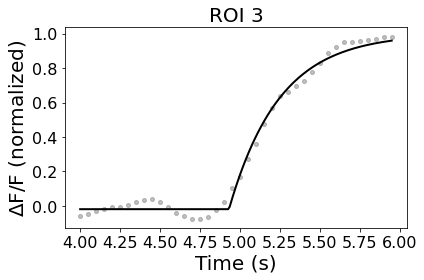

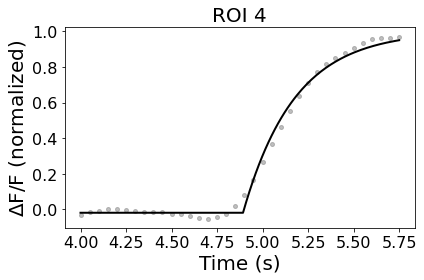

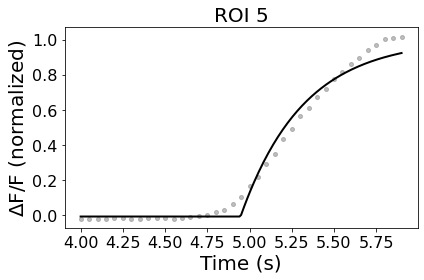

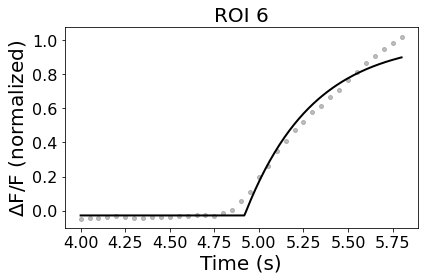

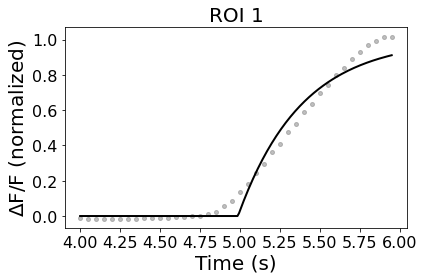

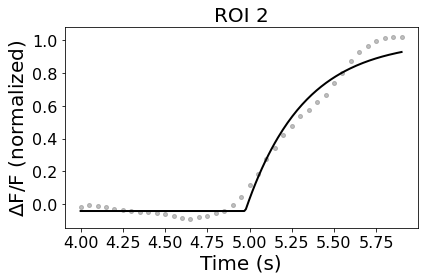

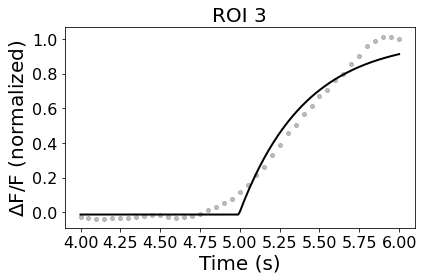

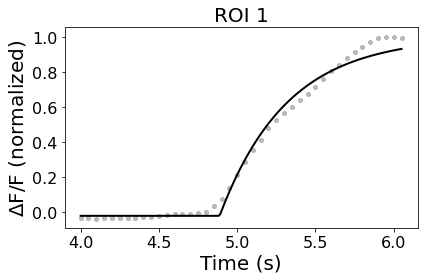

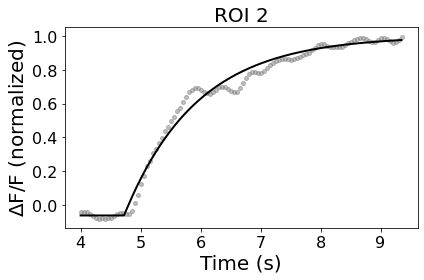

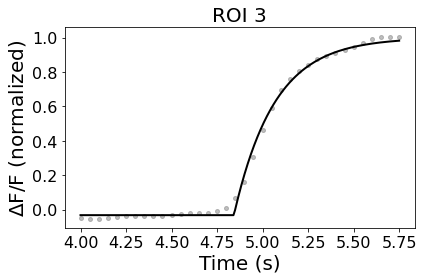

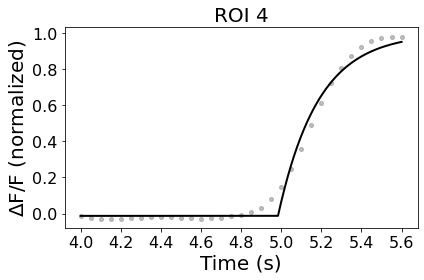

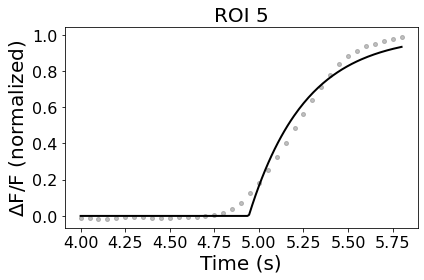

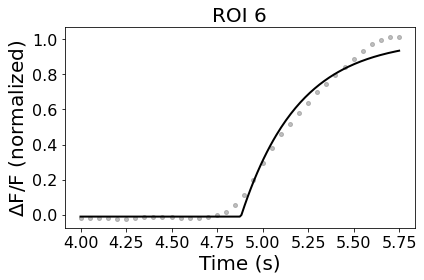

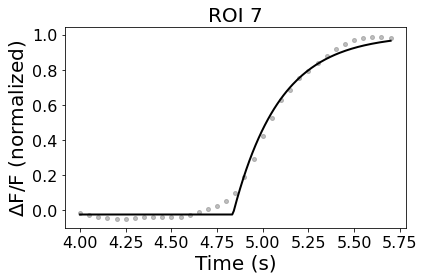

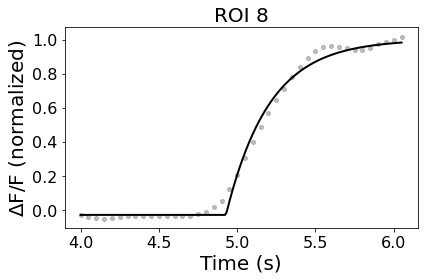

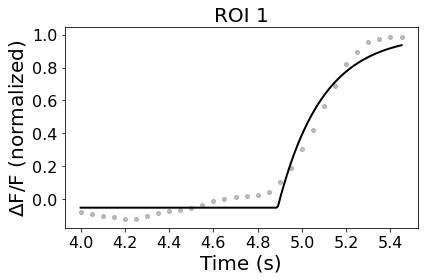

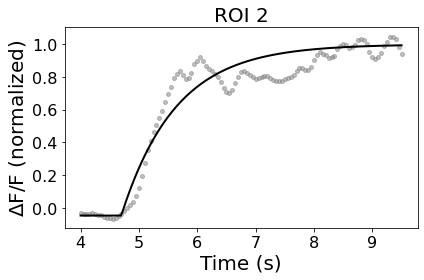

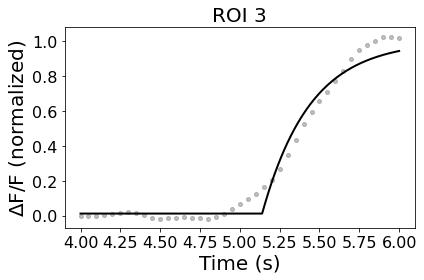

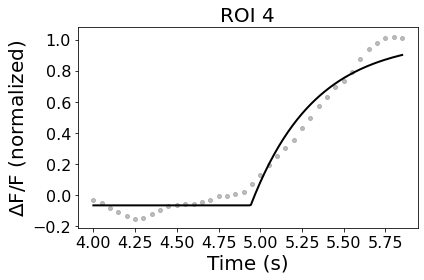

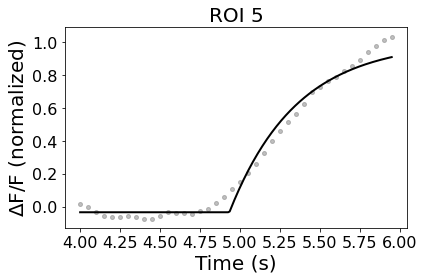

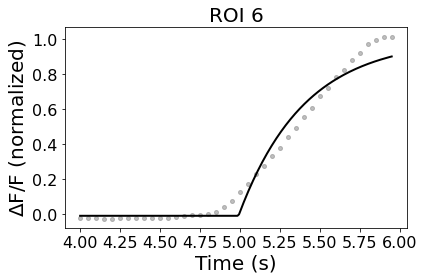

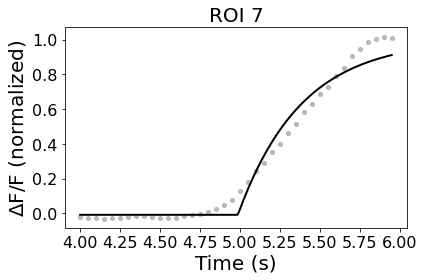

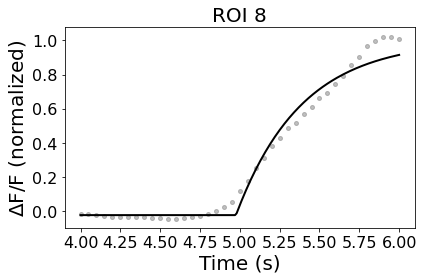

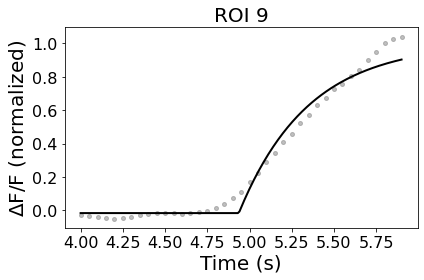

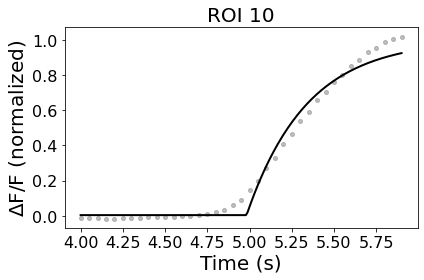

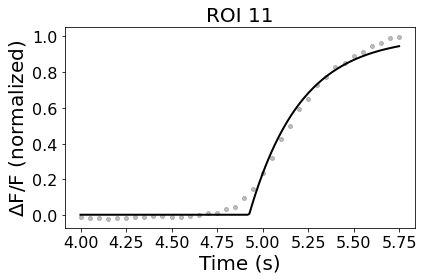

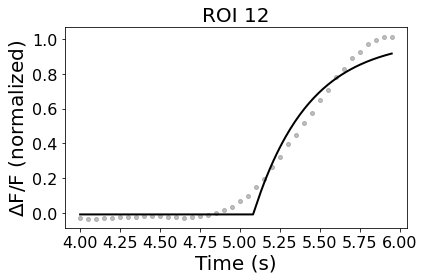

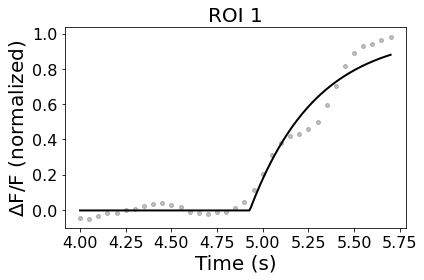

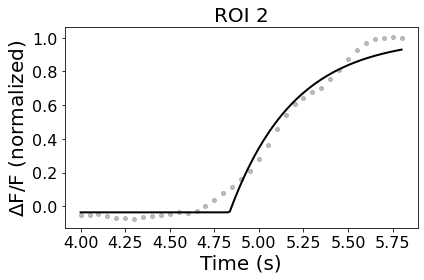

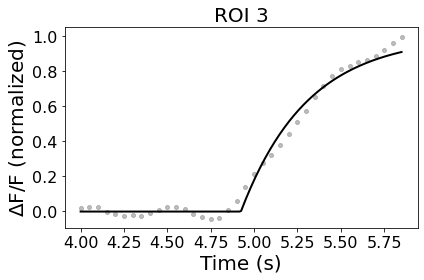

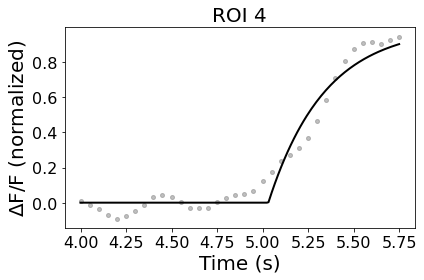

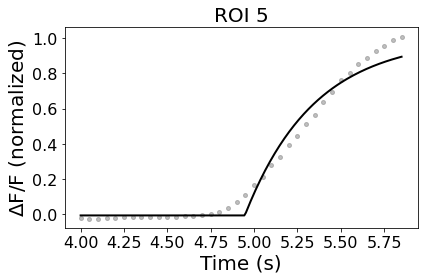

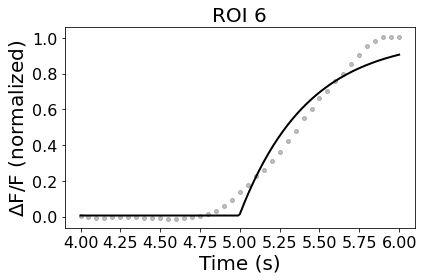

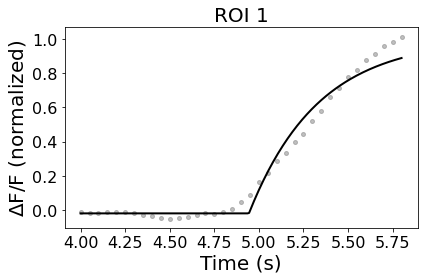

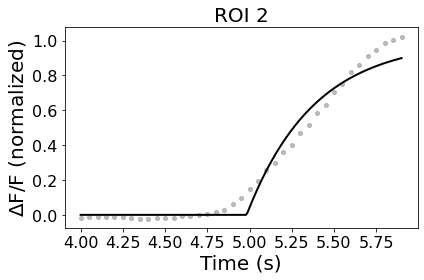

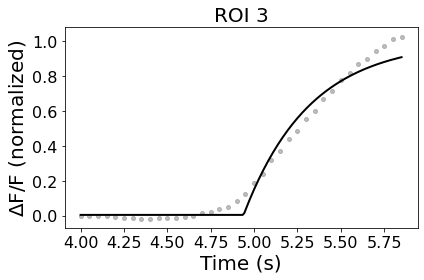

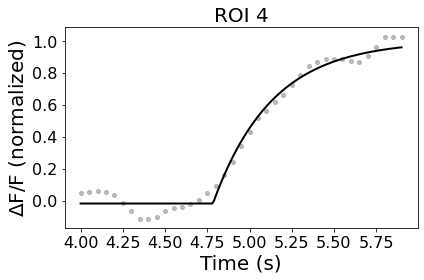

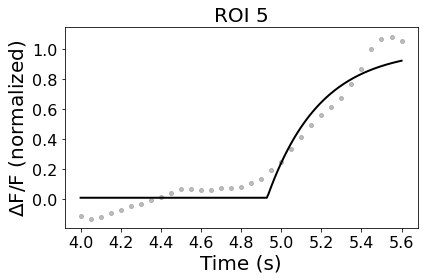

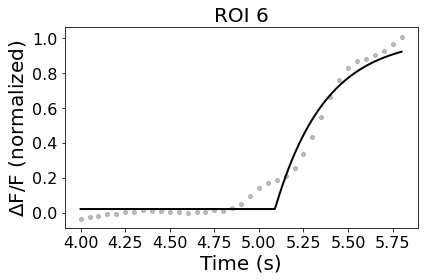

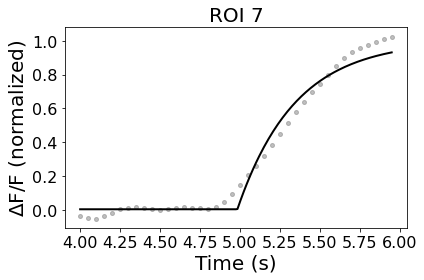

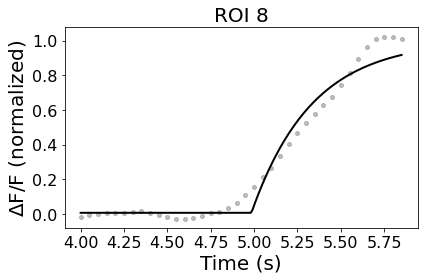

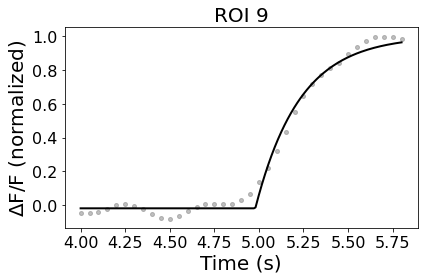

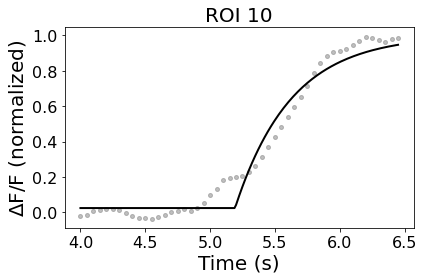

In [32]:
# get the raw data from each sheet
# define a data frame to store the results
df = pd.DataFrame({'rise_time':[],'rise_time_scale':[]})
# pre_time = 0
fit_start_time = 4
# the bound depends on the data 
bound = ([-1,fit_start_time,0.1],[0.5,10,10])
for names in sheet_names:
    df1= data.parse(names, header=None, index_col=None)
    times = time_step*np.arange(df1.shape[0])

    # calculate the mean and std of the first 1s
    pre_mean = df1.iloc[:pre_steps].mean()
    pre_std = df1.iloc[:pre_steps].std()

    # normalize the data by subtracting the mean and dividing by the mean
    df1_norm = (df1 - pre_mean)/pre_mean
    total_cols = df1_norm.shape[1]

    fig_pre = fig_pre_0 + names + '_'
    # analyze each trace
    row_names = []
    rise_time = []
    rise_time_scale = []
    for i in range(total_cols):
        trace = df1_norm.iloc[:,i]
        rise_time_curr, rise_time_scale_curr = \
        fit_rise_time(trace,fig_pre,times,fit_start_time,i,plog_flag=True,
                      start_time=pre_time,fit_bound=bound)
    # write mid_time, max2d_time, time_threshold, slope to a csv file, one sheet one file
        row_names.append(names + '_' + str(i))
        # mid_times.append(mid_time)
        rise_time.append(rise_time_curr)
        rise_time_scale.append(rise_time_scale_curr)
    df_curr = pd.DataFrame({'rise_time':rise_time,'rise_time_scale':rise_time_scale},
                           index=row_names)
    # df_curr.index = row_names
    df = df.append(df_curr)
# save the final cvs file
file_name = result_pre + '_time_summary.csv'
df.to_csv(file_name,index=True)

In [46]:
def last_index_smaller_than(vector, value):
    last_index = None
    for i, element in enumerate(vector):
        if element <= value:
            last_index = i
    return last_index

### Example trace and fit a window for rising phase

In [72]:
df1= data.parse( 'ROI20', header=None, index_col=None)
times = time_step*np.arange(df1.shape[0])

fig_pre = fig_pre_0 + 'ROI20' + '_'
# calculate the mean and std of the first 1s
pre_mean = df1.iloc[:pre_steps].mean()
pre_std = df1.iloc[:pre_steps].std()

# normalize the data by subtracting the mean and dividing by the mean
df1_norm = (df1 - pre_mean)/pre_mean
total_cols = df1_norm.shape[1]
trace = df1_norm.iloc[:,3]
pre_time = 4
bound = ([-1,4,0.1],[0.5,10,10])
rise_time, rise_time_scale, new_t, y_pred, ts, y_sel, peak = \
fit_rise_time(trace,fig_pre,times,pre_time, 1, wid_len=21, poly_order=3, 
              plog_flag = False, start_time=4, fit_bound=bound,return_fit_curve=True)

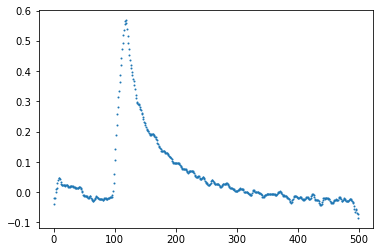

In [73]:
plt.plot(df1_norm.iloc[:,5],'.',markersize=2)

In [76]:
rise_time

4.892553658796963

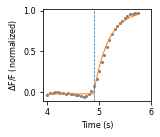

In [80]:
# figure size
fig,ax = plt.subplots(figsize=(2.4,2))
plt.plot(ts, y_sel,'o',markersize=2,color='gray')
# overlay predicted fit
plt.plot(new_t, y_pred, colors['tab:orange'], lw=1)
# set x and y labels
plt.xlabel('Time (s)',fontsize=8)
plt.ylabel(r'$\Delta$F/F (normalized)',fontsize=8)
# set x and y axis font size
# add a vertical dashed line at rise_time
plt.axvline(rise_time,linestyle='--',color=colors['tab:blue'], linewidth=0.75,label='rise time')
# set xtick label
plt.xticks([4,5,6],fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
# save as a pdf
fig_name = fig_pre_0 + 'ROI20' + '_example_trace_zoom_anotation.pdf'
plt.savefig(fig_name,dpi=300)

## Trouble-shooting

Text(0.5, 1.0, 'Smoothed Calcium Data')

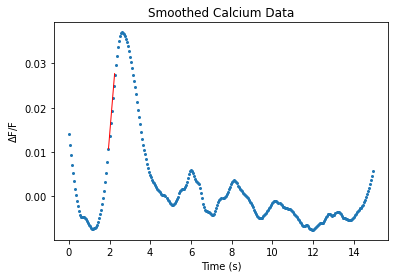

In [34]:
from scipy import stats
# seelct 7 data point around the middle peak point
time_sel = times[time_window[0]+index - 3 : time_window[0]+index + 4]
y_sel = y_filtered[time_window[0]+index - 3 : time_window[0]+index + 4]
# fit a line to the data points
slope, intercept, r_value, p_value, std_err = stats.linregress(time_sel,y_sel)

# plot the data points and the fitted line
plt.figure()
plt.plot(times, y_filtered,'o',markersize=2)
plt.plot(time_sel, slope*time_sel + intercept, 'r', lw=1)
plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$F/F')
plt.title('Smoothed Calcium Data')


Text(0.5, 0, 'Time (s)')

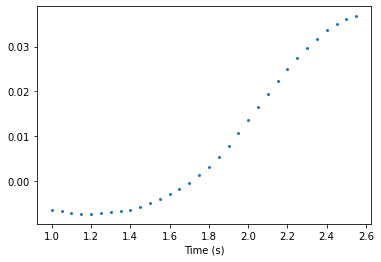

In [35]:
# use the smoothed data in the range between 1 s and peak time
time_sel = times[pre_steps:peak_index]
y_sel = y_filtered[pre_steps:peak_index]
# plot
plt.figure()
plt.plot(time_sel, y_sel,'o',markersize=2)
# plt.plot(time_sel, slope*time_sel + intercept, 'r', lw=1)
plt.xlabel('Time (s)')

Text(0.5, 1.0, 'Smoothed Calcium Data')

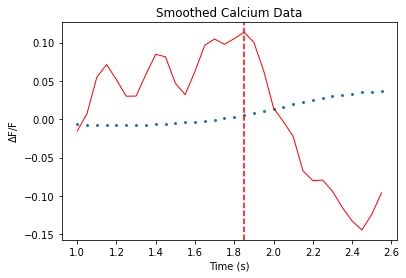

In [37]:
# find the location of largest 2nd derivative
derivative = np.gradient(y_sel, time_sel)
derivative2 = np.gradient(derivative, time_sel)
# find the index of the largest 2nd derivative
index = np.argmax(derivative2)
# find the time point of the largest 2nd derivative
time_cross = time_sel[index]
# plot the data points and the fitted line
plt.figure()
plt.plot(time_sel, y_sel,'o',markersize=2)
plt.plot(time_sel, derivative2, 'r', lw=1)
# add a vertical line to indicate the time point of the largest 2nd derivative
plt.axvline(time_cross,linestyle='--',color='r')

plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$F/F')
plt.title('Smoothed Calcium Data')
